In [1]:
import pandas as pd
import numpy as np 
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from collections import Counter
%matplotlib inline

# Needed for decision tree visualization

# Try using oversampling to help balance the data more
import pydotplus
from IPython.display import Image
# model.feature_importances
# target 1 is payment difficulties

In [2]:
path = ("../Data/application_train.csv")
df = pd.read_csv(path)
df.set_index("SK_ID_CURR", inplace = True)
df.shape

(307511, 121)

In [4]:
df = df.loc[:,["AMT_ANNUITY", 
               "TARGET", 
               "DAYS_EMPLOYED", 
               "AMT_CREDIT", 
               "AMT_INCOME_TOTAL", 
               "AMT_GOODS_PRICE", 
               "AMT_REQ_CREDIT_BUREAU_YEAR", 
               "CNT_FAM_MEMBERS", 
               "CNT_CHILDREN", 
               "NAME_EDUCATION_TYPE", 
               "DAYS_BIRTH"]]

In [5]:
df["AGE"] = round(abs(df["DAYS_BIRTH"])/365)
df = df.drop(columns = ["DAYS_BIRTH"])

In [6]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df["EDUCATION"] = le.fit_transform(df["NAME_EDUCATION_TYPE"])

In [7]:
final_df = df
final_df.drop(columns = ["NAME_EDUCATION_TYPE"], inplace = True)
# create the dummy variables for this dataframe
final_df = pd.get_dummies(final_df)
final_df

,AMT_ANNUITY,TARGET,DAYS_EMPLOYED,AMT_CREDIT,AMT_INCOME_TOTAL,AMT_GOODS_PRICE,AMT_REQ_CREDIT_BUREAU_YEAR,CNT_FAM_MEMBERS,CNT_CHILDREN,AGE,EDUCATION
SK_ID_CURR,,,,,,,,,,,
100002,24700.5,1,-637,406597.5,202500.0,351000.0,1.0,1.0,0,26.0,4
100003,35698.5,0,-1188,1293502.5,270000.0,1129500.0,0.0,2.0,0,46.0,1
100004,6750.0,0,-225,135000.0,67500.0,135000.0,0.0,1.0,0,52.0,4
100006,29686.5,0,-3039,312682.5,135000.0,297000.0,NaN,2.0,0,52.0,4
100007,21865.5,0,-3038,513000.0,121500.0,513000.0,0.0,1.0,0,55.0,4
...,...,...,...,...,...,...,...,...,...,...,...
456251,27558.0,0,-236,254700.0,157500.0,225000.0,NaN,1.0,0,26.0,4
456252,12001.5,0,365243,269550.0,72000.0,225000.0,NaN,1.0,0,57.0,4
456253,29979.0,0,-7921,677664.0,153000.0,585000.0,1.0,1.0,0,41.0,1


In [8]:
final_df.shape

(307511, 11)

In [9]:
# split the data into 70% train and 30% test, which is 307511
app_train = final_df.iloc[:216000]
app_test = final_df.iloc[91511:]

In [10]:
path_2 = ("../Data/credit_card_balance.csv")
cc_df = pd.read_csv(path_2, index_col = "SK_ID_CURR")
cc_df.head()

/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,SK_ID_PREV,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,
378907,2562384,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,1800.0,1800.0,0.000,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
363914,2582071,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,2250.0,2250.0,60175.080,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
371185,1740877,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,2250.0,2250.0,26926.425,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
337855,1389973,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,11925.0,11925.0,224949.285,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
126868,1891521,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,27000.0,27000.0,443044.395,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


In [11]:
# drop the SKIDPREV since we re going to join the two data frames and we do not need this
cc_df.drop(columns = ["SK_ID_PREV"], inplace = True)

In [12]:
train_merge = pd.merge(left = app_train, right=cc_df, how='left', left_on='SK_ID_CURR', right_on='SK_ID_CURR')
test_merge = pd.merge(left = app_test, right=cc_df, how='left', left_on='SK_ID_CURR', right_on='SK_ID_CURR')

In [13]:
# concat the two dataframes
#combined_df = pd.merge(left = final_df, right=cc_df, how='left', left_on='SK_ID_CURR', right_on='SK_ID_CURR')

In [14]:
# pull the target variables from the train_merge and test merge
target_train = train_merge["TARGET"]
target_test = test_merge["TARGET"]

In [15]:
# drop the target variables from the train and test datasets
train_merge = train_merge.drop(columns = ["TARGET"], axis =1)
test_merge = test_merge.drop(columns = ["TARGET"], axis =1)

In [16]:
# use function to help get rid of the null values
def fill_in(data):
    for i in data.columns:
        if data[i].dtype == "object":
            data[i] = data[i].fillna("")
        elif (data[i].dtype == "int64" or data[i].dtype == "float64"):
            data[i] = data[i].fillna(data[i].mean())
        else:
            pass
    return data

In [17]:
# fill the null values in both the train and the test datasets
train_merge = fill_in(train_merge)
test_merge = fill_in(test_merge)

In [18]:
# Get dummy variables for both the train and the test sets
train_merge = pd.get_dummies(train_merge)
test_merge = pd.get_dummies(test_merge)

In [24]:
# set the scaler for the mode 
scaler = StandardScaler()

In [25]:
# fit the scaler to the training data
train_merge_scaler = scaler.fit(train_merge)

In [26]:
# We now need to transform the data 
train_merge_scaled = train_merge_scaler.transform(train_merge)
test_merge_scaled = train_merge_scaler.transform(test_merge)

In [27]:
train_merge_scaled.shape

(2415716, 38)

In [32]:
# we need to fit the random forest model 
model = RandomForestClassifier(n_estimators = 50, random_state = 78)

In [33]:
# fit the model to the scaled trained data and the target training set
model = model.fit(train_merge_scaled, target_train )

In [34]:
# We need to make predictions based on the data
predictions = model.predict(test_merge_scaled)

In [35]:
# Model Evaluation
# create a confusion matrix to easily read the data evaluation
cm = confusion_matrix(target_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual Approve", "Actual Deny"], columns=["Predicted Approve", "Predicted Deny"]
)

# Calculating the accuracy score
acc_score = accuracy_score(target_test, predictions)

In [36]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(target_test, predictions))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,2252373,85
Actual 1,75533,94966


Accuracy Score : 0.9687910268320898
Classification Report
              precision    recall  f1-score   support

           0       0.97      1.00      0.98   2252458
           1       1.00      0.56      0.72    170499

    accuracy                           0.97   2422957
   macro avg       0.98      0.78      0.85   2422957
weighted avg       0.97      0.97      0.96   2422957



In [37]:
#important_features = model.feature_importances_
importances_sorted = sorted(zip(model.feature_importances_, train_merge.columns), reverse=True)
importances_sorted

[(0.11884731012758717, 'AMT_ANNUITY'),
 (0.1149989185033598, 'DAYS_EMPLOYED'),
 (0.10089813692828235, 'AMT_CREDIT'),
 (0.08901828324743104, 'AMT_INCOME_TOTAL'),
 (0.08252034965567794, 'AGE'),
 (0.07887028195150393, 'AMT_GOODS_PRICE'),
 (0.05906277579042461, 'AMT_REQ_CREDIT_BUREAU_YEAR'),
 (0.04160450658877858, 'AMT_PAYMENT_CURRENT'),
 (0.04117078394417401, 'CNT_INSTALMENT_MATURE_CUM'),
 (0.03786379671757494, 'AMT_CREDIT_LIMIT_ACTUAL'),
 (0.027182027239723593, 'CNT_FAM_MEMBERS'),
 (0.02374401298172508, 'MONTHS_BALANCE'),
 (0.020707379766647886, 'AMT_PAYMENT_TOTAL_CURRENT'),
 (0.02058730641863365, 'AMT_INST_MIN_REGULARITY'),
 (0.017601660617672134, 'AMT_BALANCE'),
 (0.01719603173639919, 'AMT_TOTAL_RECEIVABLE'),
 (0.01702984035094054, 'AMT_RECIVABLE'),
 (0.01590205514690688, 'AMT_RECEIVABLE_PRINCIPAL'),
 (0.01576424501740763, 'CNT_CHILDREN'),
 (0.012386440646226031, 'EDUCATION'),
 (0.007478380049426489, 'AMT_DRAWINGS_CURRENT'),
 (0.006395134151729649, 'AMT_DRAWINGS_POS_CURRENT'),
 (0.0061

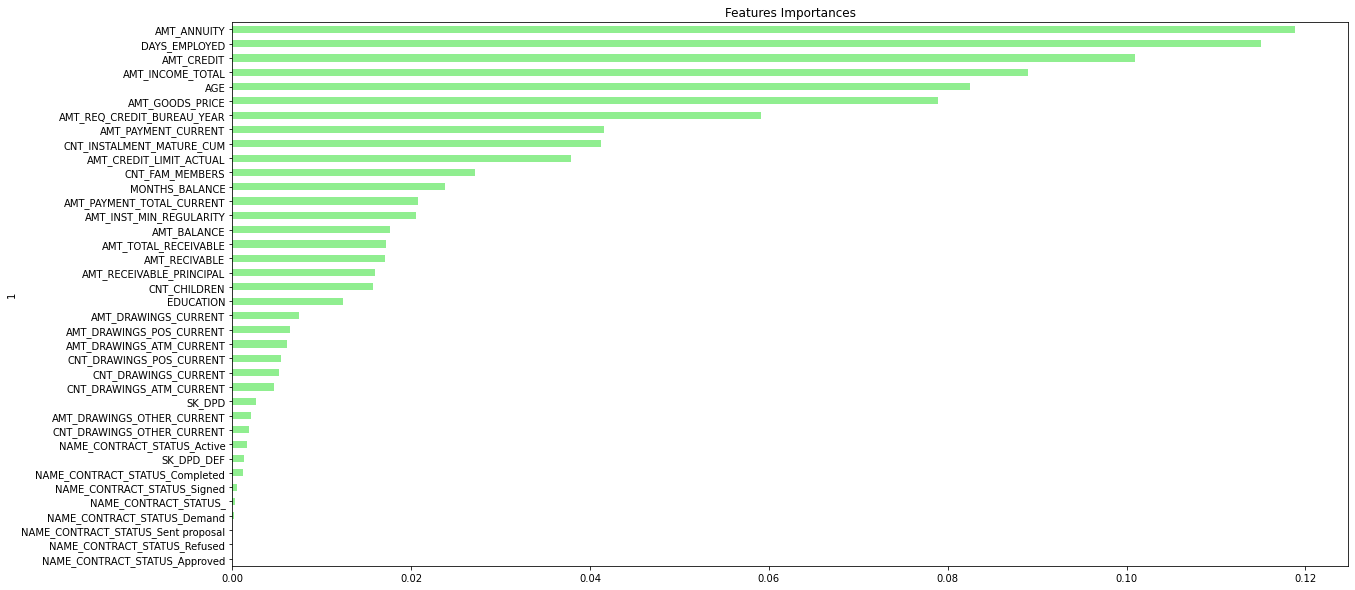

In [38]:
# Visualize the features by importance
importances_df = pd.DataFrame(sorted(zip(model.feature_importances_, train_merge.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances')
importances_sorted.plot(kind='barh', color='lightgreen', title= 'Features Importances', legend=False, figsize = (20,10))

In [39]:
# We need to make predictions based on the trained data
predictions_2 = model.predict(train_merge_scaled)

In [40]:
# Calculating the accuracy score for the train set
acc_score_2 = accuracy_score(target_train, predictions_2)
acc_score_2

0.999926729797708

In [41]:
# compare the accuracy scores to determine if overfitting is happening
print(f'The accuracy score for the test data is {acc_score} and the accuracy score for the train data is {acc_score_2}')

The accuracy score for the test data is 0.9687910268320898 and the accuracy score for the train data is 0.999926729797708
